In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
pd.set_option('display.max_columns', 1000)

import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm, skew, probplot
import scipy.stats as stats
from functools import partial

from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge as krr
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train_id = train["Id"]
test_id = test["Id"]

print(f"train shape before drop id {train.shape}")
train.drop('Id', axis=1, inplace=True)
print(f"train shape after drop id {train.shape}")
print(" ")
print(f"train shape before drop id {test.shape}")
test.drop('Id', axis=1, inplace=True)
print(f"train shape after drop id {test.shape}")

train shape before drop id (1460, 81)
train shape after drop id (1460, 80)
 
train shape before drop id (1459, 80)
train shape after drop id (1459, 79)


# EDA

Let's analysis the target variable first

In [4]:
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

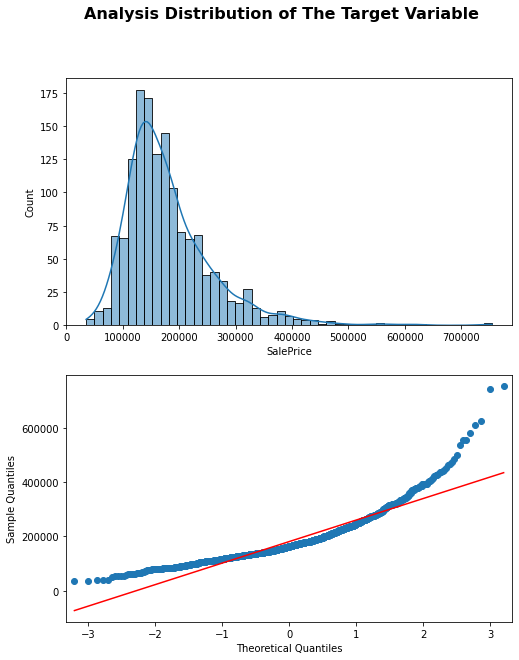

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
fig.suptitle('Analysis Distribution of The Target Variable', fontsize=16, fontweight='bold')

sns.histplot(train["SalePrice"], kde=True, ax=ax[0])

fig = sm.qqplot(train["SalePrice"], line="s", ax=ax[1])

plt.show()

Based on the histogram and qqplot visualizations, it appears that the distribution of the target variable is skewed towards the left. Furthermore, the data points in the qqplot exhibit a noticeable deviation from the reference line, indicating a departure from normality.

Now let's analysis our independent variables

In [6]:
categorical_datas = [data for data in train.columns if train[data].dtypes == "object"]
print(categorical_datas) 

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [7]:
numeric_datas = [data for data in train.columns if train[data].dtypes != "object"]
print(numeric_datas)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [8]:
all_data = pd.concat((train, test)).drop("SalePrice", axis=1)

missing_values = all_data.isnull().sum() / len(all_data) * 100
missing_values = missing_values.sort_values(ascending=False)
missing_count = all_data.isnull().sum()
missing_df = pd.DataFrame([missing_values, missing_count], index=["missing_percent", "missing_count"]).T
missing_df.head(25)

,missing_percent,missing_count
PoolQC,99.657417,2909.0
MiscFeature,96.402878,2814.0
Alley,93.216855,2721.0
Fence,80.438506,2348.0
FireplaceQu,48.646797,1420.0
LotFrontage,16.649538,486.0
GarageYrBlt,5.447071,159.0
GarageFinish,5.447071,159.0
GarageQual,5.447071,159.0
GarageCond,5.447071,159.0


Let's see all the numerical and categorical data distributions

C:\Users\USER\AppData\Local\Temp\ipykernel_15744\3192554821.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(7, 6, i + 1)


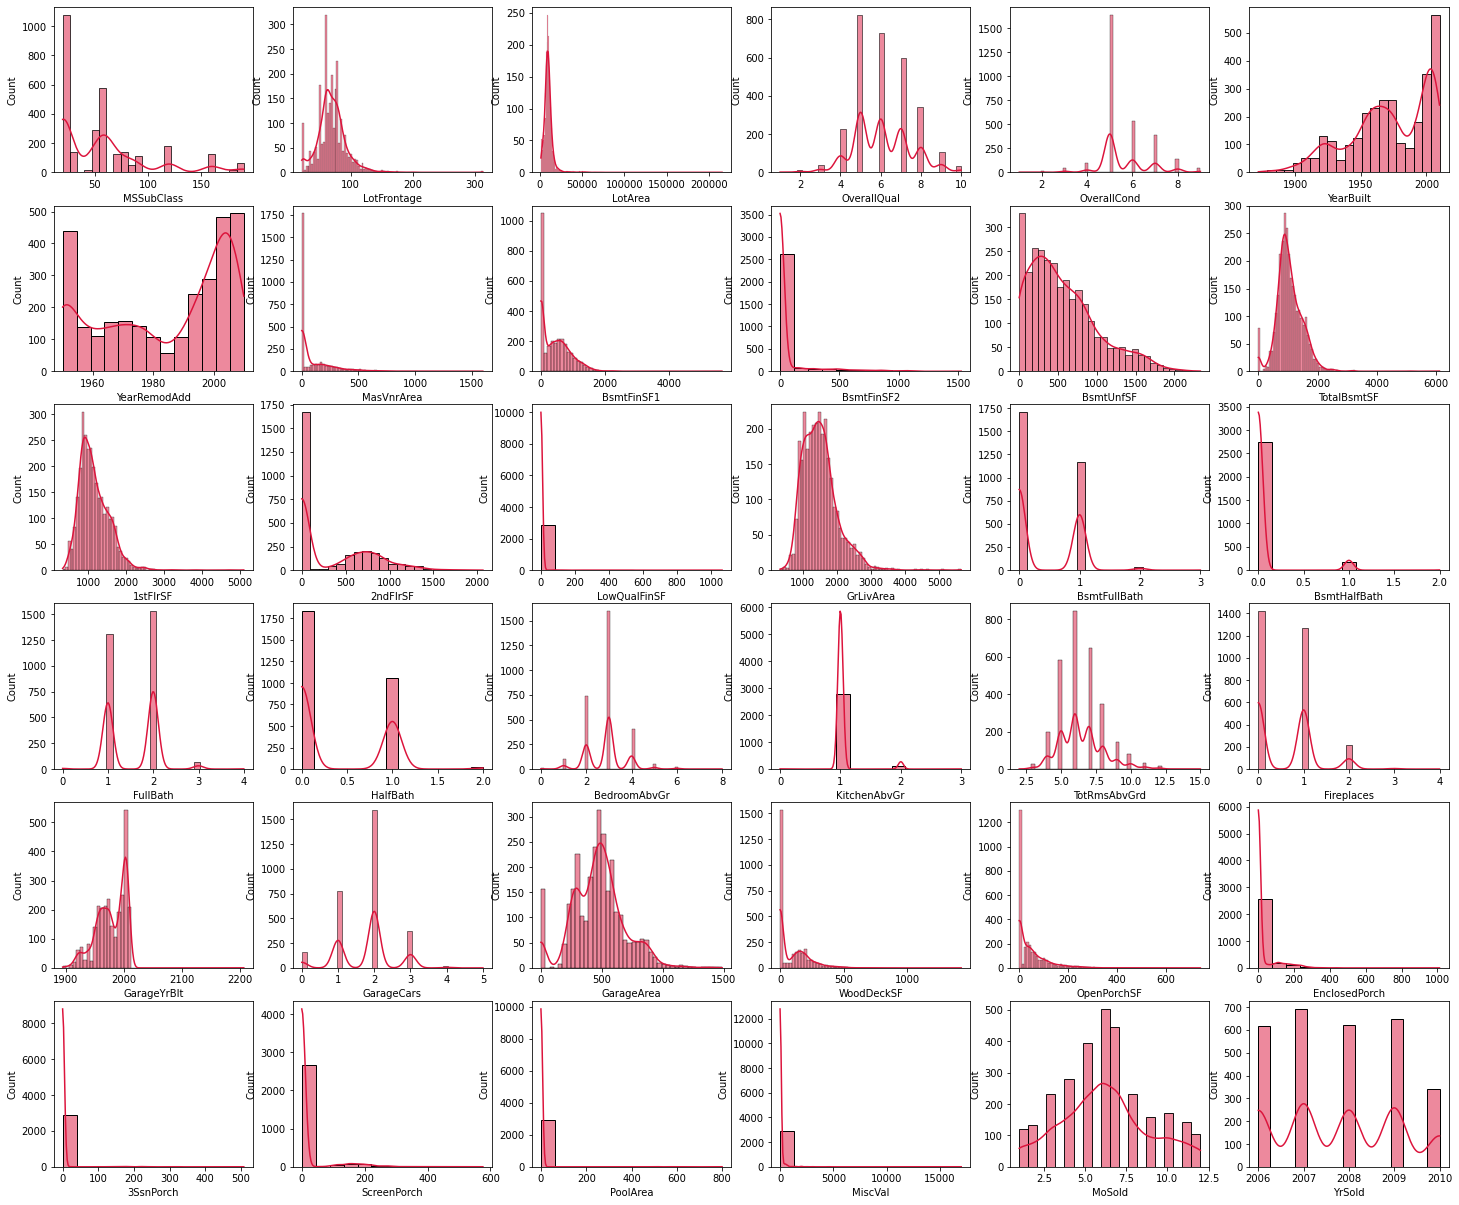

In [9]:
plt.subplots(figsize=(25, 25), facecolor='white')
numeric_var = [numeric for numeric in all_data.columns if all_data[numeric].dtypes != "object"]

for i, j in enumerate(numeric_var):
    plt.subplot(7, 6, i + 1)
    g = sns.histplot(all_data[j], color='crimson', kde=True)

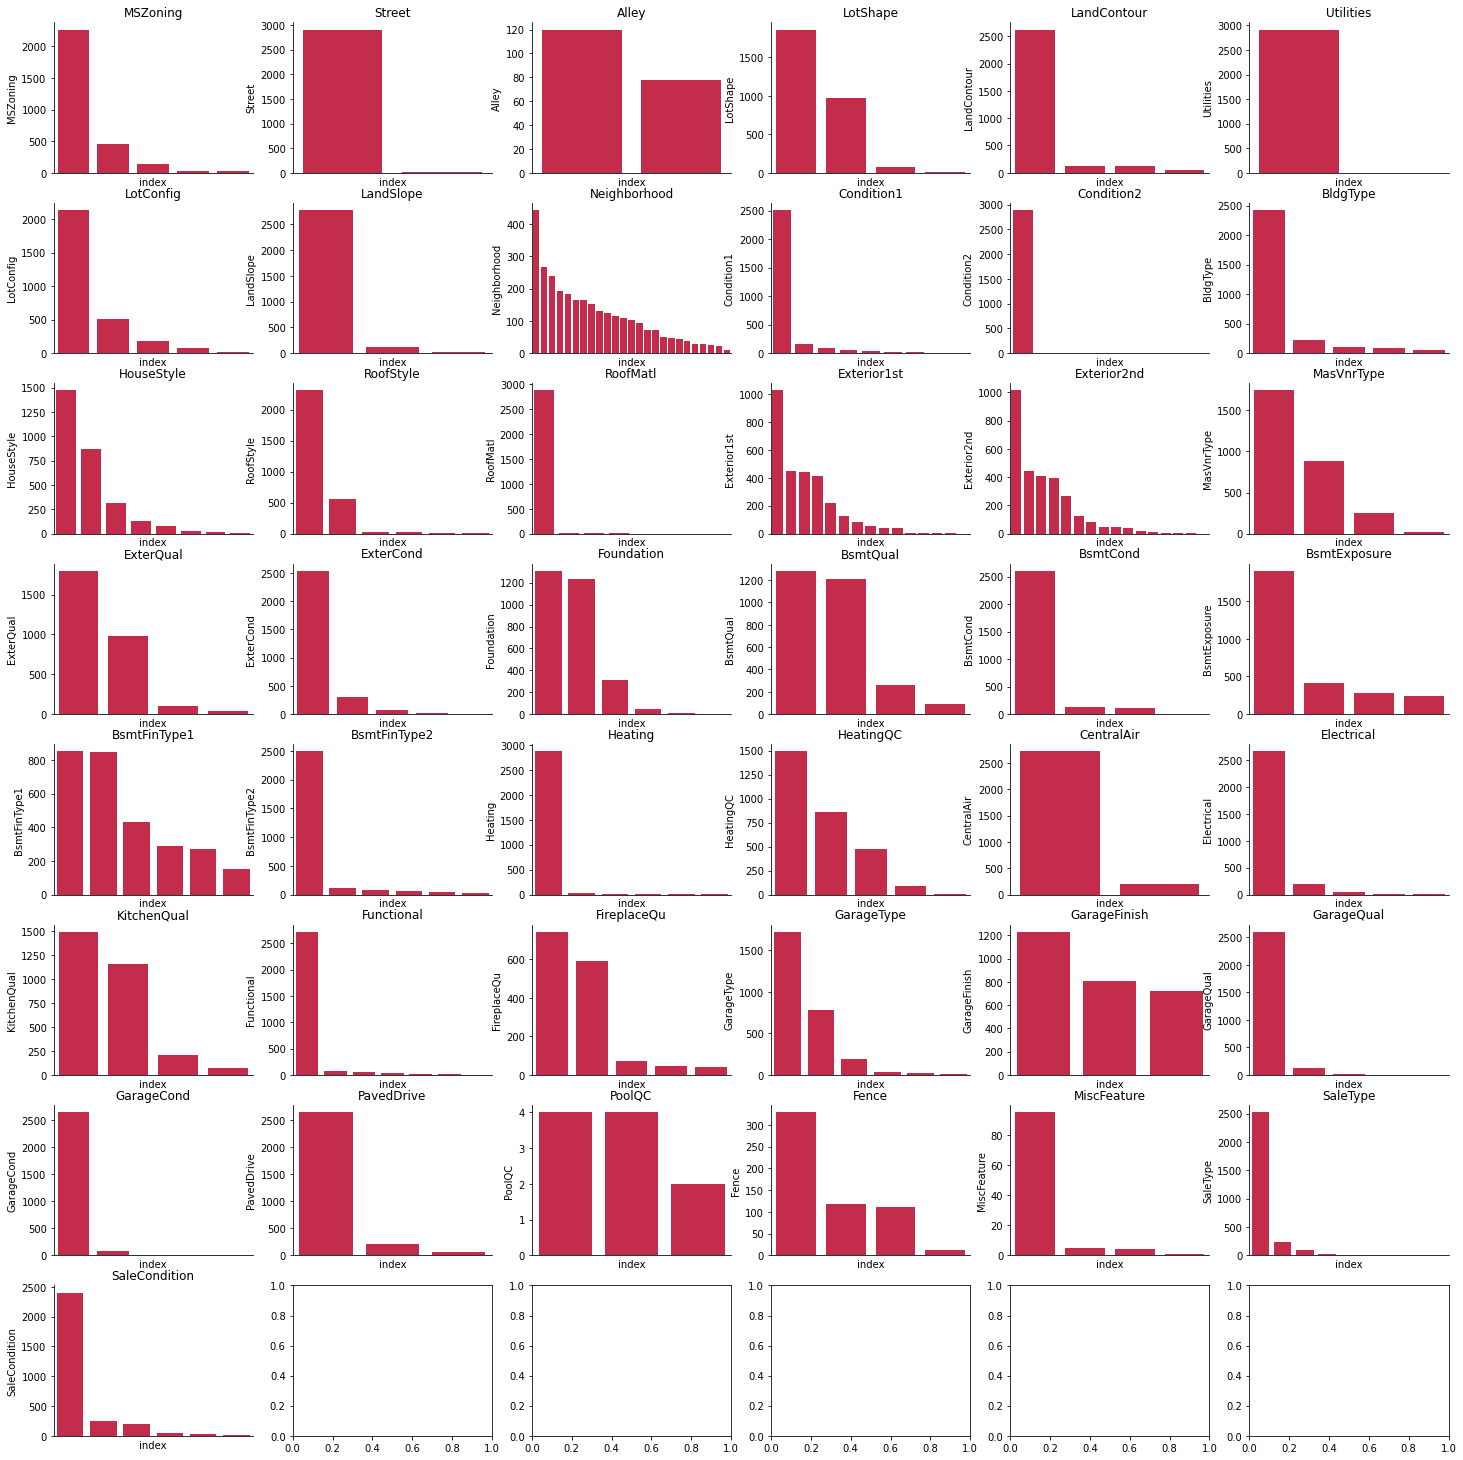

In [10]:
f, ax = plt.subplots(8, 6, figsize=(25, 26), facecolor='white')
cat_vars = all_data.columns[all_data.dtypes == 'object']
for i, c in enumerate(cat_vars):
    g = sns.barplot(data=pd.DataFrame(all_data[c].value_counts()).reset_index(), x='index', y=c, ax=ax[i//6, i%6], color='crimson')
    g.set(xticks=[])
    g.set(title=c)
    g.set_facecolor('white')
    g.spines[['top', 'right']].set_visible(False)


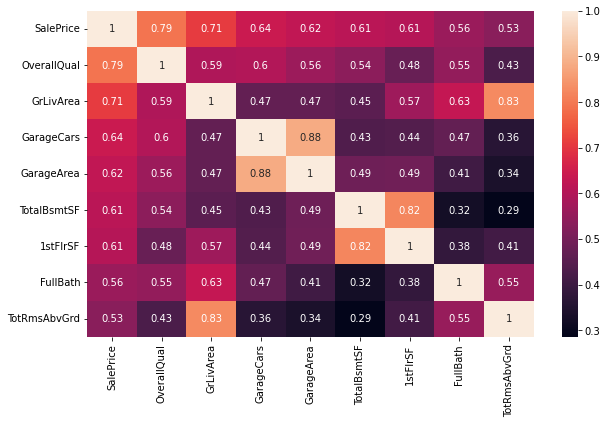

In [11]:
f, ax = plt.subplots( figsize=(10, 6))
corr = train.corr()["SalePrice"].abs().sort_values(ascending=False)[:9].index
sns.heatmap(train[corr].corr(), annot=True)
plt.show()

Improved explanation of assumptions for a good regression model:

1. Linearity: It is important to ensure a linear relationship between the independent variable(s) and the dependent variable. To achieve linearity, techniques such as variable transformation or increasing the dimensions can be employed.

2. Homoscedasticity: The residuals should exhibit constant variance across all levels of the independent variable. To test for homoscedasticity, a residual plot can be created. If the points in the plot randomly scatter around a baseline, it indicates equal variance and satisfies the assumption.

3. Independence: Independence assumes that there should be no correlation among the independent variables. High correlation between independent variables leads to multicollinearity, which can significantly affect the model's performance.

4. Absence of Autocorrelation: There should be no correlation between the residuals. The Durbin-Watson test is commonly used to check for autocorrelation, indicating non-correlation if the test statistic falls within the acceptable range.

In [12]:
def hypothesis_test(x, y , categorical=False):
    f, ax = plt.subplots(1, 4, figsize=(30, 5))
    if categorical:
        sns.boxplot(x=train[x], y=train[y], ax=ax[0])
    else:
        sns.regplot(x=train[x], y=train[y], ax=ax[0])
        
    sns.residplot(x=train[x], y=train[y], ax=ax[1])
    sm.qqplot(train[x], line="s", ax=ax[2])
    sns.histplot(x=train[x] ,ax=ax[3], kde=True)
        
       
    plt.show()

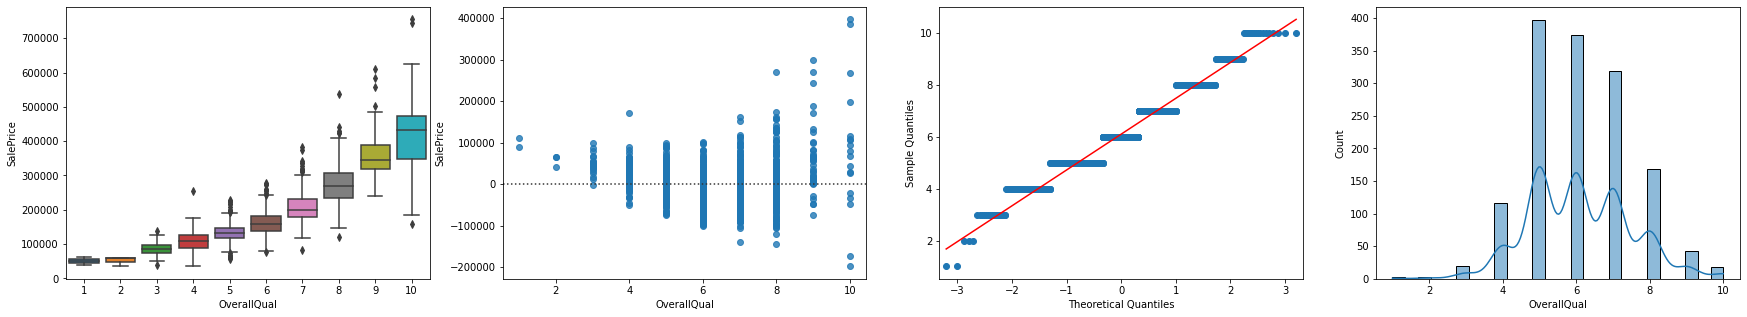

In [13]:
hypothesis_test('OverallQual', 'SalePrice', True)

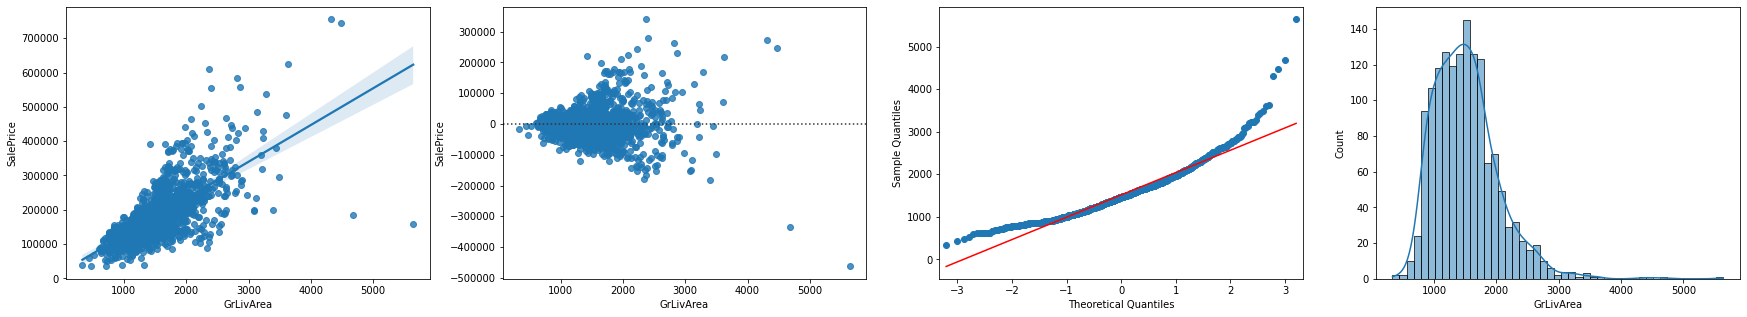

In [14]:
hypothesis_test('GrLivArea', 'SalePrice')

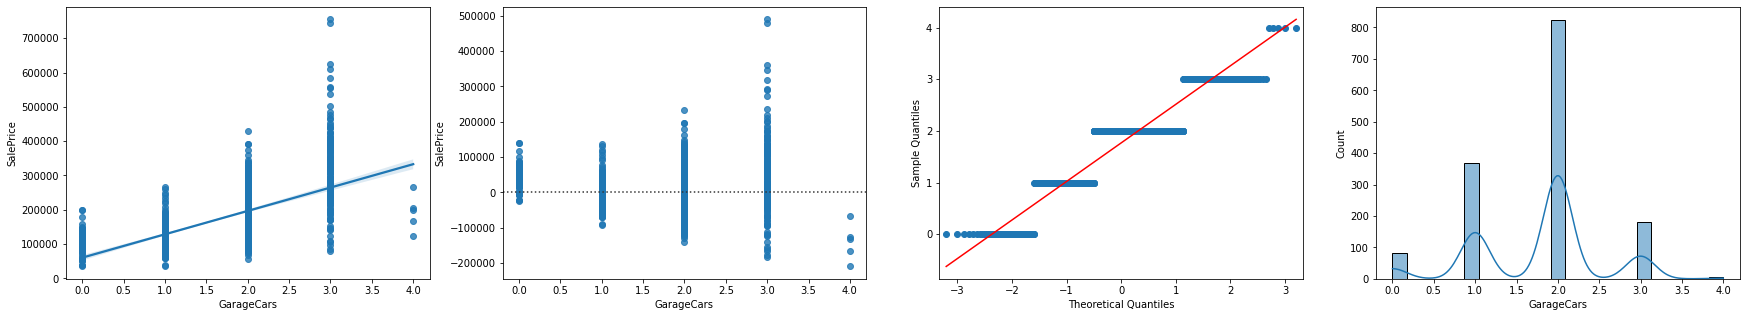

In [15]:
hypothesis_test("GarageCars", "SalePrice")

In [16]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: abs(skew(x))).sort_values(ascending=False)
skewed_df =  pd.DataFrame([skewed_feats], index=['skew']).T
skewed_df[skewed_df["skew"] > 0.5]

,skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
KitchenAbvGr,4.302254
EnclosedPorch,4.003891
ScreenPorch,3.946694
OpenPorchSF,2.535114
WoodDeckSF,1.842433


After analyzing the data, I found that the variables OverallQual, GrLivArea, and GarageArea have a strong linear relationship with the SalePrice. I used scatterplots for numeric variables and boxplots for categorical variables to visually confirm this relationship.

Based on these visualizations, it is evident that these variables are important factors in predicting the SalePrice accurately. To ensure the reliability of our analysis, I  also conducted tests to check if the assumptions of homoscedasticity, normality, and independence hold.

For homoscedasticity, I examined a residual plot. To assess normality, I used a QQ plot and a histogram. These diagnostic plots provide insights into whether our model assumptions are valid.






# Feature Engineering

Remove Outliers

Finding outliers
1. Statistics for univariate - normal distribution, IQR:
For independent variables, points outside the threshold can be judged as outliers using normal distributions, likelihood functions, IQR, etc.
2. Scattering point:
If you draw a scatterplot of two variables with a pattern (e.g., a linear relationship), you can intuitively find outliers.
I previously found some variables that have a strong correlation with the dependent variable. 
3. Clustering - DBSCAN:
DBSCAN can detect outliers using distance.
DBSCAN has a set range (epsilon) and required peripheral points (min_samples), and generates clusters by calculating key points and peripheral points. Points that do not have key points around and do not have the minimum required neighboring points are outliers.

Instead of relying only on traditional statistical methods to find unusual data points, we'll use a more advanced technique called DBSCAN. This method helps us identify outliers in a smarter way. For example, when we look at a scatterplot of the GrLivArea variable, we might see a couple of points that seem different from the others at the top right. However, we can't simply label them as outliers without further investigation.

To make accurate decisions, we need to thoroughly understand the data and check if there is a clear pattern or relationship. This way, we can be sure that those points are truly unusual and not just a result of random variation. By using the DBSCAN algorithm, which considers the density and position of data points, we can take a more careful approach in identifying outliers. This helps us avoid making simple assumptions and ensures that our analysis is more reliable.

In summary, by being mindful of the data and choosing appropriate outlier detection methods like DBSCAN, we can confidently detect and handle unusual observations, leading to more accurate and trustworthy analysis outcomes.


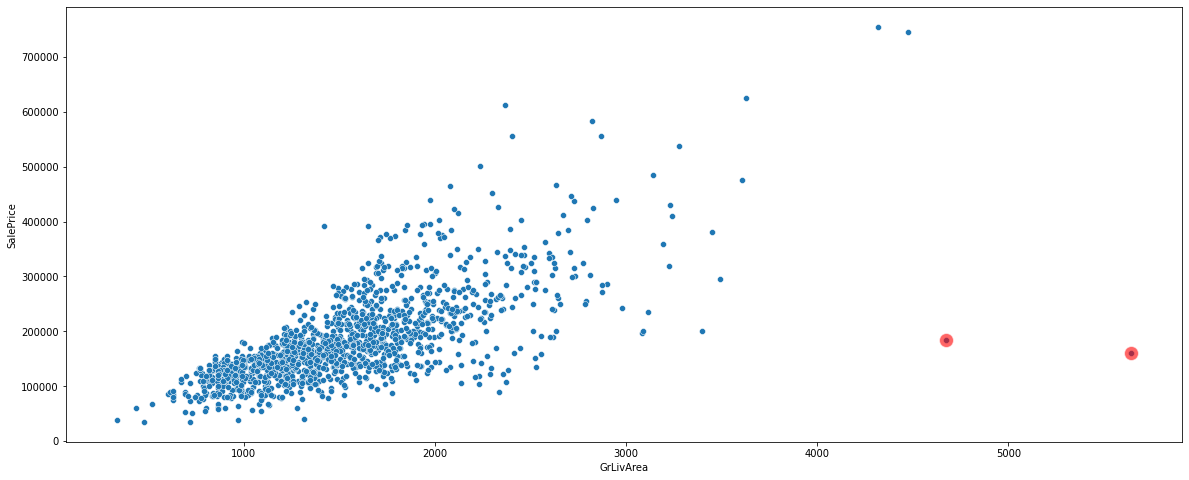

In [17]:
plt.subplots(figsize=(20,8))
outlier = train["GrLivArea"].sort_values(ascending=False)[:2].index
sns.scatterplot(x=train['GrLivArea'], y=train.SalePrice)
sns.scatterplot(x=train.loc[outlier, 'GrLivArea'], y=train.loc[outlier, 'SalePrice'], color='red',  s=200, alpha=.6)
plt.show()

In [18]:
data_scaled = pd.DataFrame(StandardScaler().fit_transform(train[["SalePrice", "GrLivArea"]]), columns=["SalePrice", "GrLivArea"])

In [19]:
dbscan_model = DBSCAN(eps=1.5, min_samples=3).fit(data_scaled)
dbscan_df = pd.concat((data_scaled, pd.DataFrame(dbscan_model.labels_, columns=["label"])), axis=1)

In [20]:
dbscan_df["label"].value_counts()

 0    1456
-1       4
Name: label, dtype: int64

In [21]:
dbscan_df[dbscan_df["label"] == -1]

,SalePrice,GrLivArea,label
523,0.048212,6.016627,-1
691,7.228819,5.331304,-1
1182,7.102899,5.635892,-1
1298,-0.263440,7.855574,-1


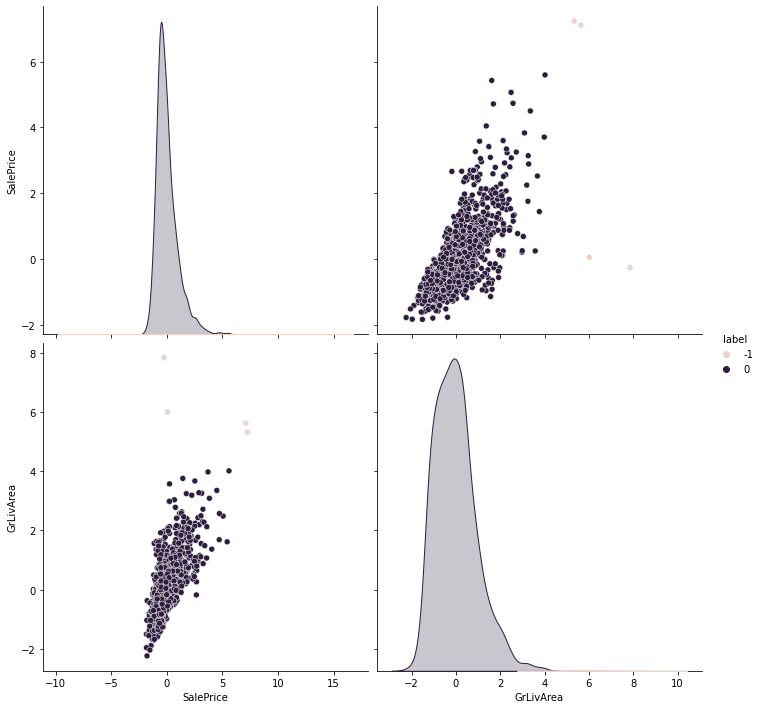

In [22]:
sns.pairplot(dbscan_df, hue="label", height=5)
plt.show()

In [23]:
train.drop(train["GrLivArea"].sort_values(ascending=False)[:2].index, axis=0, inplace=True)

Two outliers were found through the scatterplot. Two points were removed.
In the case of DBSCAN, a total of 4 points were judged as outliers.

To effectively handle missing values and transform numeric variables, we will merge the test and train data. This allows us to apply consistent transformations and address missing values in a unified manner. and i will separating for the dependent variable.

In [24]:
all_data = pd.concat((train , test), axis=0).reset_index(drop=True)
y_train = train.SalePrice.values
all_data.drop("SalePrice", axis=1, inplace=True)

In [25]:
train_size = train.shape[0]

In [26]:
print(f"data_merged shape: {all_data.shape}, train shape: {train.shape}, test shape: {test.shape}, y_train shape: {y_train.shape}")

data_merged shape: (2917, 79), train shape: (1458, 80), test shape: (1459, 79), y_train shape: (1458,)


Handle missing values

Based on the description of each variable, I applied the following treatments:

1. For continuous variables: I replaced missing values with the median value of each category, considering a relevant categorical variable. If a missing value was expected in the variable, I replaced it with 0.

2. For categorical variables: I examined the distribution of values using the value_counts method. If there were values without negative meanings (such as NA or POOL), I replaced them with None. Additionally, for categorical variables related to specific categories, I identified the distribution of values within each category and replaced the least common value with a more suitable alternative.

Variables that are currently missing.

In [27]:
missing_columns = []
for column in all_data:
    if all_data[column].isnull().sum() > 0:
        missing_columns.append(column)

print(missing_columns)

['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [28]:
for c in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
          'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC",
          'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
    all_data[c] = all_data[c].fillna('None')
    
for c in ['GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1',
          'BsmtFinSF2','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
          'BsmtUnfSF','TotalBsmtSF']:
    all_data[c] = all_data[c].fillna(0)

for c in ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']:
    all_data[c] = all_data[c].fillna(all_data[c].mode()[0])

all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [29]:
all_data.isnull().sum().sum()

0

Transform numeric variables - LabelEncoder, Boxcox, Log, OneHotEncoding, Adding some variables

To ensure normality and equal variance of continuous variables, log and Box-Cox transformations were applied. These transformations help to achieve a more symmetric distribution and stabilize variance in the data.

For ordered variables representing priorities, label encoding was used.

Log transformation was applied to the dependent variable to ensure its normality. This transformation helps to approximate a normal distribution, which is often beneficial for statistical modeling and analysis.

In [30]:
train[['MSSubClass', 'GarageYrBlt', 'MoSold', 'OverallCond', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'YrSold']] = train[['MSSubClass', 'GarageYrBlt', 'MoSold', 'OverallCond', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'YrSold']].astype('str')

In [31]:
order_cols = [
    'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageYrBlt', 'GarageQual',
    'GarageCond', 'PoolQC', 'MoSold', 'YrSold'
]

In [32]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = pd.DataFrame(skewed_feats[abs(skewed_feats) > 0.5], columns=["skew"])
high_skew


,skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [33]:
skewness = high_skew[abs(high_skew) > 0.5]
skewed_feats = skewness.index
lam = 0.15

for feature in skewed_feats:
    all_data[feature] = boxcox1p(all_data[feature],  boxcox_normmax(all_data[feature] + 1))

C:\Users\USER\Documents\anaconda\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\USER\Documents\anaconda\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


In [34]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = pd.DataFrame(skewed_feats[abs(skewed_feats) > 0.5], columns=["skew"])
high_skew

,skew
PoolArea,15.595057
3SsnPorch,8.862045
LowQualFinSF,8.492615
MiscVal,5.237983
BsmtHalfBath,3.779434
KitchenAbvGr,3.778336
ScreenPorch,3.152631
BsmtFinSF2,2.578329
EnclosedPorch,2.149132
MasVnrArea,0.977618


In [35]:
for c in order_cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [36]:
y_train = np.log1p(y_train)

In [37]:
all_data['TotalSF'] = (all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))                              
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF'])

In [38]:
all_data = pd.get_dummies(all_data)

Select variables

In [39]:
all_data.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1, inplace=True)

In [40]:
all_data.shape

(2917, 244)

Training, test data division

In [41]:
x_train, x_test = all_data.iloc[:train_size, :], all_data.iloc[train_size:, :]

In [42]:
def rmsle_cv(model):
    return np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring='neg_mean_squared_error',
                   cv=5, verbose=0, n_jobs=-1))

In [43]:
model_lasso = Pipeline([
     ('scaler', RobustScaler()),
     ('model', Lasso())
 ])
model_elasticNet = Pipeline([
     ('scaler', RobustScaler()),
     ('model', ElasticNet(max_iter=5000))
])
model_krr = Pipeline([
     ('scaler', RobustScaler()),
     ('model', krr())
])

model_svr = Pipeline([
     ('scaler', RobustScaler()),
     ('model', SVR())
 ])

#for hyper paramater tunning
grid_param_lasso = {
    'model__alpha': 0.0001 * np.arange(1, 1000)
}

grid_param_elasticNet = {
    'model__alpha': 0.0001 * np.arange(1, 1000),
    'model__l1_ratio': 0.001 * np.arange(1, 100)
}

grid_param_krr = {
    'model__alpha': 0.0001 * np.arange(1, 1000),
    'model__degree': [1, 2, 3],
    'model__kernel': ['polynomial'],
    'model__coef0': [2.5]
}

grid_param_svr = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__gamma': [.0001, .0002, .0003, .0004, .0005, .0006, .0007, .0008, .0009, .001],
    'model__epsilon': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]
}

best_params = {}

In [44]:
"""
search_lasso = GridSearchCV(model_lasso, grid_param_lasso, scoring='neg_mean_squared_error',
                            cv=5, n_jobs=-1, verbose=0).fit(x_train, y_train)
best_params['Lasso'] = search_lasso.best_params_
best_params
    """

"\nsearch_lasso = GridSearchCV(model_lasso, grid_param_lasso, scoring='neg_mean_squared_error',\n                            cv=5, n_jobs=-1, verbose=0).fit(x_train, y_train)\nbest_params['Lasso'] = search_lasso.best_params_\nbest_params\n    "

In [45]:
"""
search_elasticNet = GridSearchCV(model_elasticNet, grid_param_elasticNet, scoring='neg_mean_squared_error',
                            cv=5, n_jobs=-1, verbose=0).fit(x_train, y_train)
best_params['ElasticNet'] = search_elasticNet.best_params_
best_params
    """

"\nsearch_elasticNet = GridSearchCV(model_elasticNet, grid_param_elasticNet, scoring='neg_mean_squared_error',\n                            cv=5, n_jobs=-1, verbose=0).fit(x_train, y_train)\nbest_params['ElasticNet'] = search_elasticNet.best_params_\nbest_params\n    "

In [46]:
"""
search_krr = GridSearchCV(model_krr, grid_param_krr, scoring='neg_mean_squared_error',
                            cv=5, n_jobs=-1, verbose=0).fit(x_train, y_train)
best_params['KernelRidge'] = search_krr.best_params_
best_params
    """

"\nsearch_krr = GridSearchCV(model_krr, grid_param_krr, scoring='neg_mean_squared_error',\n                            cv=5, n_jobs=-1, verbose=0).fit(x_train, y_train)\nbest_params['KernelRidge'] = search_krr.best_params_\nbest_params\n    "

In [47]:
"""
search_svr = GridSearchCV(model_svr, grid_param_svr, scoring='neg_mean_squared_error',
                            cv=5, n_jobs=-1, verbose=0).fit(x_train, y_train)
best_params['SVR'] = search_svr.best_params_
best_params
    """

"\nsearch_svr = GridSearchCV(model_svr, grid_param_svr, scoring='neg_mean_squared_error',\n                            cv=5, n_jobs=-1, verbose=0).fit(x_train, y_train)\nbest_params['SVR'] = search_svr.best_params_\nbest_params\n    "

In [48]:
from sklearn.metrics import mean_squared_error

def objective_xgb(trial, X, y):
    param = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    train_scores, test_scores = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = XGBRegressor(**param)
    for train_idx, test_idx in kf.split(X):
        tmp_X_train, tmp_X_test = x_train.iloc[train_idx, :], x_train.iloc[test_idx, :]
        tmp_y_train, tmp_y_test = y_train[train_idx], y_train[test_idx]
        model.fit(tmp_X_train, tmp_y_train,
                  eval_set=[(tmp_X_test, tmp_y_test)], eval_metric=['rmse'],
                  early_stopping_rounds=30, verbose=0,
                  callbacks=[optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-rmse')])
    train_score = np.sqrt(mse(tmp_y_train, model.predict(tmp_X_train)))
    test_score = np.sqrt(mse(tmp_y_test, model.predict(tmp_X_test)))
    train_scores.append(train_score)
    test_scores.append(test_score)
    train_score = np.array(train_scores).mean()
    test_score = np.array(test_scores).mean()
    print(f'train score: {train_score}')
    print(f'test score: {test_score}')
    return test_score

In [49]:
#optimizer_xgbr = partial(objective_xgb, X=x_train, y=y_train)
#study_xgbr = optuna.create_study(direction='minimize')
#study_xgbr.optimize(optimizer_xgbr, n_trials=300)
#best_params['XGBoost'] = study_xgbr.best_params

In [50]:
def objective_lgbr(trial, X, y):
    param = {
    'objective': 'regression',
    'num_leaves': trial.suggest_int('num_leaves', 100, 4096),  # Increased upper limit to 4096
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
    'n_estimators': trial.suggest_int('n_estimators', 100, 10000),  # Increased upper limit to 10000
    'max_bin': trial.suggest_int('max_bin', 200, 2000),  # Increased upper limit to 2000
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 50),  # Increased upper limit to 50
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 1.0),
    'bagging_seed': trial.suggest_int('bagging_seed', 1, 1000),
    'feature_fraction_seed': trial.suggest_int('feature_fraction_seed', 1, 1000),
}

    train_scores, test_scores = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = LGBMRegressor(**param)
    for train_idx, test_idx in kf.split(X):
        tmp_X_train, tmp_X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        tmp_y_train, tmp_y_test = y[train_idx], y[test_idx]
        model.fit(tmp_X_train, tmp_y_train,
                  eval_set=[(tmp_X_test, tmp_y_test)],
                  eval_metric='rmse',
                  early_stopping_rounds=30,
                  verbose=False)
        train_score = np.sqrt(mean_squared_error(tmp_y_train, model.predict(tmp_X_train)))
        test_score = np.sqrt(mean_squared_error(tmp_y_test, model.predict(tmp_X_test)))
        train_scores.append(train_score)
        test_scores.append(test_score)

    test_score = np.mean(test_scores)
    return test_score

In [51]:
#optimizer_lgbr = partial(objective_lgbr, X=x_train, y=y_train)
#study_lgbr = optuna.create_study(direction='minimize')
#study_lgbr.optimize(optimizer_lgbr, n_trials=300)
#best_params['LightGBM'] = study_lgbr.best_params

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

def objective_gbr(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 1.0]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'loss': trial.suggest_categorical('loss', ['squared_error', 'quantile', 'absolute_error', 'huber'])
    }

    train_scores, test_scores = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = GradientBoostingRegressor(**param)
    
    for train_idx, test_idx in kf.split(X):
        tmp_X_train, tmp_X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        tmp_y_train, tmp_y_test = y[train_idx], y[test_idx]
    
        model.fit(tmp_X_train, tmp_y_train)
    
        # Evaluate on validation set
        train_score = np.sqrt(mean_squared_error(tmp_y_train, model.predict(tmp_X_train)))
        test_score = np.sqrt(mean_squared_error(tmp_y_test, model.predict(tmp_X_test)))
        train_scores.append(train_score)
        test_scores.append(test_score)

    

    test_score = np.mean(test_scores)
    return test_score

In [53]:
#optimizer_gbr = partial(objective_gbr, X=x_train, y=y_train)
#study_gbr = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
#study_gbr.optimize(optimizer_gbr, n_trials=250)
#best_params['GBR'] = study_gbr.best_params

Modeling

In [56]:
model_lasso = Pipeline([
     ('scaler', RobustScaler()),
     ('model', Lasso(alpha = 0.0005))
 ])
model_elasticNet = Pipeline([
     ('scaler', RobustScaler()),
     ('model', ElasticNet(alpha=   0.0034000000000000002, l1_ratio=  0.099, random_state=3))])

model_krr = Pipeline([
     ('scaler', RobustScaler()),
     ('model', krr( alpha=0.0471,
                kernel='polynomial',
                degree=1,
                coef0=2.5))
])

model_svr = Pipeline([
     ('scaler', RobustScaler()),
     ('model', SVR(C= 100, epsilon= 0.02, gamma=0.0001))])


model_gbr = gbr(n_estimators=4489, learning_rate=0.009873351433680528,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=3, min_samples_split=6, 
                                   loss='huber')

model_xgbr = XGBRegressor (colsample_bytree=0.5, learning_rate= 0.006038145364847455, max_depth=5, 
                             n_estimators=2200, reg_alpha= 0.4942069091561331, reg_lambda= 7.573392485219034,
                         subsample=0.6, min_child_weight= 14)

model_lgbm = LGBMRegressor(objective='regression', 
                                        num_leaves=330, learning_rate=   0.009118154500110243, n_estimators= 9718,
                                       max_bin= 256, bagging_fraction=  0.6560723698043952, bagging_freq= 9, 
                                       bagging_seed= 723, feature_fraction=  0.24022206347939662, feature_fraction_seed=387,
                                    )

stack_gen = StackingCVRegressor(regressors=(model_lgbm, model_lasso, model_elasticNet, model_krr, model_svr, model_gbr),
                               meta_regressor=model_xgbr,
                               use_features_in_secondary=True)

In [57]:
models = [
    model_lasso, model_elasticNet, model_krr, model_svr, model_gbr, model_xgbr, model_lgbm
]
cross_score = {
    'Lasso': 0,
    'ElasticNet': 0,
    'Kernel Ridge': 0,
    'SVR': 0,
    'GradientBoosting': 0,
    'XGBoost': 0,
    'LightGBM': 0,
}

for index, model in enumerate(models):
    cross_score[list(cross_score.keys())[index]] = rmsle_cv(model).mean()


In [58]:
cross_score

{'Lasso': 0.10910538397006793,
 'ElasticNet': 0.11000720361305072,
 'Kernel Ridge': 0.1115619455559951,
 'SVR': 0.10965161855117982,
 'GradientBoosting': 0.10981795520236896,
 'XGBoost': 0.11892819681088918,
 'LightGBM': 0.1191473624044613}

In [59]:
def blend(X):
    return ((0.10 * model_lasso.predict(X)) + \
            (0.10 * model_elasticNet.predict(X)) + \
            (0.10 * model_krr.predict(X)) + \
            (0.10 * model_svr.predict(X)) + \
            (0.10 * model_xgbr.predict(X)) + \
            (0.10 * model_lgbm.predict(X)) + \
            (0.40 * stack_gen.predict(np.array(X))))

In [60]:
for model in models:
    model = model.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.24022206347939662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24022206347939662
[LightGBM] [Warning] bagging_fraction is set=0.6560723698043952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6560723698043952
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


In [61]:
stack_gen = stack_gen.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.24022206347939662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24022206347939662
[LightGBM] [Warning] bagging_fraction is set=0.6560723698043952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6560723698043952
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.24022206347939662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24022206347939662
[LightGBM] [Warning] bagging_fraction is set=0.6560723698043952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6560723698043952
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.24022206347939662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24022206347939662
[LightGBM] [Warning] b

In [62]:
np.sqrt(mse(y_train, blend(x_train)))

0.06948941528163363

In [63]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = score = np.expm1(blend(x_test))

In [67]:
sub.to_csv('submission.csv',index=False)